In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from datetime import date, datetime, timedelta
from scipy import stats


sns.set_style("darkgrid")

In [39]:
end_date = date.today()

# period = "daily"
period = "hourly"

if period == "daily":
    # Daily
    start_date = "2017-01-01"
    interval = "1d"
    
elif period == "hourly":
    # Hourly
    start_date = "2021-03-01"
    interval = "1h"

ticker = "CL=F"
df = yf.download(ticker, start=start_date, end=end_date.strftime("%Y-%m-%d"), interval=interval)

# Assess the closing price
df.rename(columns={"Adj Close": "price"}, inplace=True)
df.drop(columns=["Open", "High", "Low", "Close", "Volume"], inplace=True)

df["cap_gain"] = df["price"].diff()
df["returns"] = df["price"].pct_change()
df["log_returns"] = np.log(df["price"]/df["price"].shift(1))

df.dropna(inplace=True)
df.tail()

[*********************100%***********************]  1 of 1 completed


,price,cap_gain,returns,log_returns
2023-02-24 12:00:00-05:00,76.019997,-0.250000,-0.003278,-0.003283
2023-02-24 13:00:00-05:00,76.120003,0.100006,0.001316,0.001315
2023-02-24 14:00:00-05:00,76.459999,0.339996,0.004467,0.004457
2023-02-24 15:00:00-05:00,76.589996,0.129997,0.001700,0.001699
2023-02-24 16:00:00-05:00,76.449997,-0.139999,-0.001828,-0.001830


In [40]:
standardise = False

if standardise:
    df["returns"] = (df["returns"] - df["returns"].mean()) / df["returns"].std()
    df["log_returns"] = (df["log_returns"] - df["log_returns"].mean()) / df["log_returns"].std()
    df.tail()

Cap Gain:  -7.938997650146485 12.938997650146485
Return:  -0.0767411364321346 0.11287999324746395
Log Ret:  -0.07903984619630604 0.10766267631146265


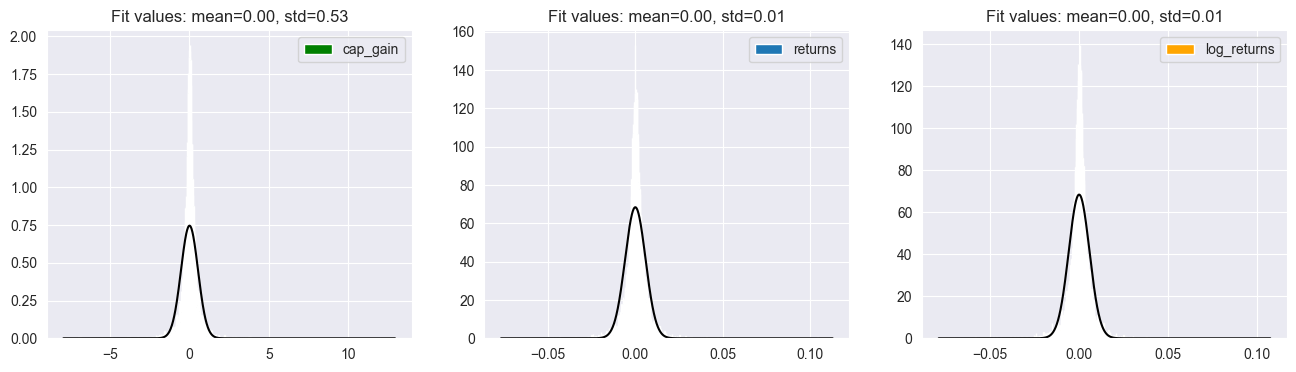

In [41]:
# Histograms of data.
num_bins = int(np.round(len(df) / 10))
alpha = 1.0

fig = plt.figure()
fig.set_size_inches(16, 4)

# Capital Gain
plt.subplot(1, 3, 1)
plt.hist(df["cap_gain"], bins=num_bins, density=True, alpha=alpha, color="green", label="cap_gain")

# Normal Distribution PDF(x).
mean, std = stats.norm.fit(df["cap_gain"])
xmin, xmax = plt.xlim()
print("Cap Gain: ", xmin, xmax)
x = np.linspace(xmin, xmax, num_bins)
pdf = stats.norm.pdf(x, mean, std)
plt.plot(x, pdf, color="k")
plt.title(f"Fit values: mean={mean:.2f}, std={std:.2f}")
plt.legend()

# Simple Returns.
plt.subplot(1, 3, 2)
plt.hist(df["returns"], bins=num_bins, density=True, alpha=alpha, label="returns")

# Normal Distribution PDF(x).
mean, std = stats.norm.fit(df["returns"])
xmin, xmax = plt.xlim()
print("Return: ", xmin, xmax)
x = np.linspace(xmin, xmax, num_bins)
pdf = stats.norm.pdf(x, mean, std)
plt.plot(x, pdf, color="k")
plt.title(f"Fit values: mean={mean:.2f}, std={std:.2f}")
plt.legend()

# Log Returns.
plt.subplot(1, 3, 3)
plt.hist(df["log_returns"], bins=num_bins, density=True, alpha=alpha, color="orange", label="log_returns")

# Normal Distribution PDF(log(x)).
mean, std = stats.norm.fit(df["log_returns"])
xmin, xmax = plt.xlim()
print("Log Ret: ", xmin, xmax)
x = np.linspace(xmin, xmax, num_bins)
pdf = stats.norm.pdf(x, mean, std)
plt.plot(x, pdf, color="k")
plt.title(f"Fit values: mean={mean:.2f}, std={std:.2f}")
plt.legend()
plt.show()

# Random Kelly

In [42]:
returns = "cap_gain"
# returns = "returns"
# returns = "log_returns"

xmin = df[returns].min()
xmax = df[returns].max()

xmin, xmax

(-6.989997863769531, 11.989997863769531)

In [48]:
num_bins = 1000
x = np.linspace(xmin, xmax, num_bins)

mean, std = stats.norm.fit(df[returns])
pdf = stats.norm.pdf(x, mean, std)


# Transaction Costs.
cost = 0.01

# Positive Outcomes.
x_pos = x.copy()
x_pos[x_pos < cost] = 0.0
pos = np.sum(x_pos*pdf)

# Negative Outcomes.
x_neg = x.copy()
x_neg[x_neg > cost] = 0.0
neg = np.sum(x_neg*pdf)

# All Outcomes.
tot = np.sum(np.abs(x)*pdf)

print(f"pos = {pos}")
print(f"neg = {neg}")

R = np.abs(pos) / np.abs(neg)
print(f"R = {R}")

num_wins = len(df.query(f"{returns} > {cost}"))
W = num_wins / len(df)
print(f"W = {W}")

kelly = W - (1 - W)/R
print(f"Kelly = {kelly}")
print(f"Kelly % = {100.0*kelly}")

pos = 11.256795627453974
neg = -11.192389155802143
R = 1.005754488229034
W = 0.49876040375420577
Kelly = 0.00038868171656047945
Kelly % = 0.038868171656047945


# Random Kelly With Stops

In [44]:
# Take profit at 100*a% increase.
a = 0.05

# Stop loss at 100*b% decrease.
b = a - cost

# Probability the investment increase. ABS - AREA under curve.
p = np.sum(x_pos*pdf) / np.sum(np.abs(x)*pdf)
q = 1 - p

kelly = (p/a) - (q/b)

print(f"Prob = {p}")
print(f"Kelly = {kelly}")

Prob = 0.5013800924063196
Kelly = -2.4378958417156156


Prob = 0.5013800924063196
Kelly = [-24.79298614 -23.95696018 -23.16382637 ...  -0.0723553   -0.07220873
  -0.07206258]


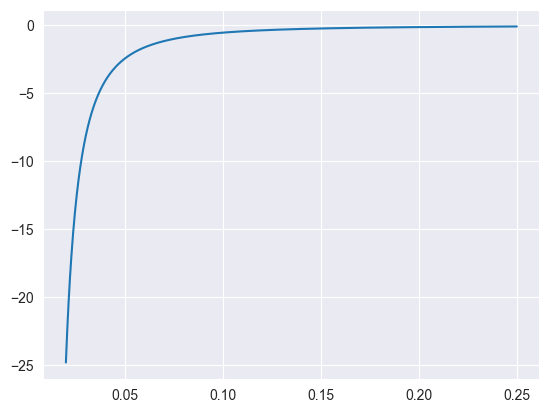

In [47]:
# Take profit at 100*a% increase.
a = np.linspace(cost+0.01, 0.25, 1001)

# Stop loss at 100*b% decrease.
b = a - cost

# Probability the investment increase. ABS - AREA under curve.
p = np.sum(x_pos*pdf) / np.sum(np.abs(x)*pdf)
q = 1 - p

kelly = (p/a) - (q/b)

print(f"Prob = {p}")
print(f"Kelly = {kelly}")

plt.plot(a, kelly)

# Non-Normal

In [51]:
from fitter import Fitter, get_common_distributions, get_distributions

Fitting 5 distributions: 100%|█████████████████████████████████████████| 5/5 [00:00<00:00,  7.58it/s]

{'lognorm': {'s': 0.004778674806253795, 'loc': -1.2181065891253673, 'scale': 1.2181443532680345}}


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,5812.229204,7119.015634,-7474.692034,inf,0.098942,1.073623e-96
norm,5842.052505,7393.481041,-7426.221254,inf,0.099733,3.029677e-98
gamma,5842.531358,7358.316749,-7415.963534,inf,0.099792,2.326895e-98
beta,5856.928410,7404.798865,-7378.835286,inf,0.099976,1.008457e-98
burr,14966.742398,1183.985066,3217.254943,inf,0.245910,0.000000e+00


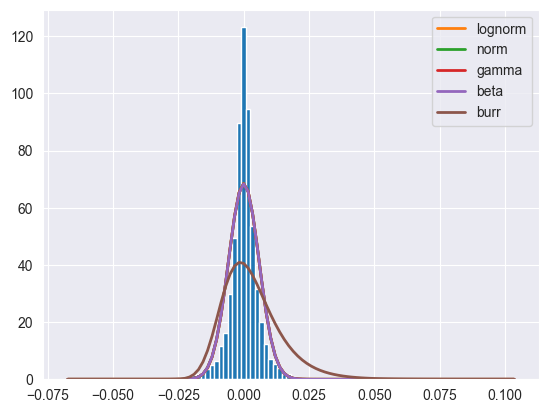

In [63]:
ret = df["returns"].values


f = Fitter(ret, distributions=["gamma", "lognorm", "beta", "burr", "norm"])
f.fit()

print(f.get_best(method="sumsquare_error"))
f.summary()

Fitting 5 distributions: 100%|█████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]

{'lognorm': {'s': 0.004772996617716005, 'loc': -1.2175962703418328, 'scale': 1.2176135876811638}}


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,5835.574223,6640.393513,-7429.420151,inf,0.099565,6.471883e-98
norm,5895.215834,6811.157548,-7323.909417,inf,0.100508,8.962262e-100
beta,5935.162620,6883.771674,-7228.973801,inf,0.101002,9.367355e-101
burr,14518.200723,1237.026523,2873.606967,inf,0.236442,0.000000e+00
gamma,41470.207489,-110.832456,14718.143288,inf,0.579079,0.000000e+00


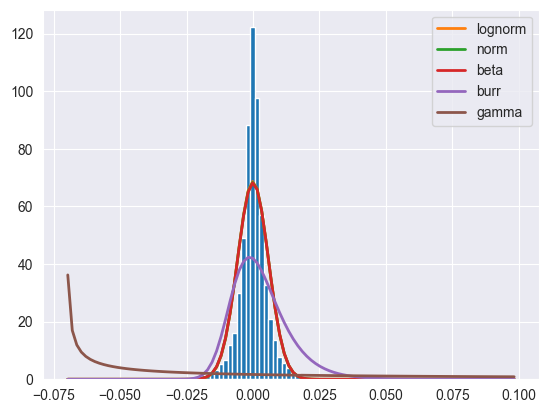

In [64]:
ret = df["log_returns"].values


f = Fitter(ret, distributions=["gamma", "lognorm", "beta", "burr", "norm"])
f.fit()

print(f.get_best(method="sumsquare_error"))
f.summary()